# OHW 2021 - Xtractopy

**Participants:** Andrew Chin, Felippe Galdino, Laura McDonnell, Kyle Oliveira, Bruna Ramos & Jackie Veatch

This Jupyter Notebook outlines the `xtractopy` and `xtractopy2` functions in Python, created during the 2021 Ocean Hack Week. Similar to the R/MATLAB `xtractomatic` package, these functions match tag data from marine animals to broad-scale environmental data from servers, and returns a tidy dataframe that is easily visualized and analyzed in R. To do this, we match `xarray` coordinates to a `pandas` dataframe by consolidating the gridded environmental data into points.

*Inputs:*
1. tag data of latitude, longitude, and date/time from the animal in a `pandas` df
2. environmental dataset(s) as an `xarray` DataSet
3. filename

*Outputs*
1. a `.csv` file containing tag coordinates and corresponding environmental variables

## Generalized function `xtractopy()`

In [1]:
# necessary packages
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
from typing import Dict, Union
import fsspec
import matplotlib.pyplot as plt
from datetime import datetime 

In [2]:

def xtractopy(envdata,
              tagdata: pd.DataFrame,
             filename: [str]):
    """
    envdata: environmental data in an DataArray format
    tagdata: tag data in a pandas format
    filename: the name of the file .csv output file, as a "string"
    """
    def fuction_dataset_point(**kwargs) -> Dict[str, Union[float, int]]:
        pass

    def extract(function_dataset_point, 
                df: tagdata, 
                map_coordinates: Dict[str, str], 
                rename_variables: Dict[str, str]
               ) -> pd.DataFrame:
        """
        function_dataset_point: environmental data in a point format, to be transformed
        map_coordinates: key is name of column in dataframe, value is the name of the coordinate in dataset
        rename_variables: TBD
        """
    
        def get_row(row) -> Dict[str, Union[float, int]]:
            extract_coordinates = {}
        
            for key, val in map_coordinates.items():
                extract_coordinates[val] = row[key]
        
            result = function_dataset_point(**extract_coordinates)
        
            # rename variables here and transform result TBD
            return result
    
        return df.apply(
            lambda row: get_row(row), axis=1, result_type="expand"
        )


    def envdata_point(lat, lon, time) -> Dict[str, Union[float, int]]:
        ds = envdata.sel(lat=lat, lon=lon, time=time, method="nearest")

        results = {}
    
        for var in ds.variables:
            if var not in ds.coords:
                results[var] = ds[var].values
    
        return results

    combined_dat = pd.concat([tagdata, 
                        extract(envdata_point,
                                tagdata, 
                                {"lat": "lat", "lon": "lon", "datetime": "time"}, 
                                {}
                               )
                       ], axis=1)
    combined_dat.to_csv("".join([filename, ".csv"])) # need to figure out how to paste the title into the csv file
    return combined_dat


## Tutorial
Below is an example of an `xtractopy` workflow from OHW 2021. We will be working with tiger sharks (*Galeocerdo cuvier*) tagged in the Gulf Stream system of the Western Atlantic Ocean.

![tigershark](tigershark_lauramcdonnell.png)

First, let's load in the track data:

{'latitude': slice(24.44818354, 35.90428483, None),
 'longitude': slice(-82.06428163, -71.04951667, None)}

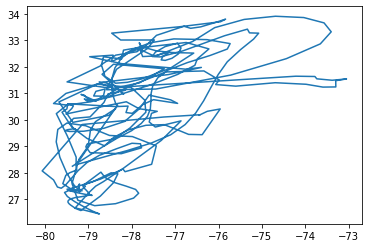

In [4]:
shark_dir = "shark_track_data/track_shark144020.csv"
track_ex = pd.read_csv(shark_dir, parse_dates=['datetime']) # in pandas, read_csv

# track_ex["lon"] = np.where(
#     track_ex["lon"] < 180,
#     track_ex["lon"] + 360,
#     track_ex["lon"])

lat_min = track_ex["lat"].min() - 2.0
lat_max = track_ex["lat"].max() + 2.0
lon_min = track_ex["lon"].min() - 2.0
lon_max = track_ex["lon"].max() + 2.0

xy_bbox = dict(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))

plt.plot(track_ex.lon,track_ex.lat)

xy_bbox

In [5]:
track_ex

,lon,lat,datetime
0,-78.984392,27.187935,2014-11-15
1,-78.952825,27.172386,2014-11-16
2,-78.924598,27.156750,2014-11-17
3,-78.912462,27.146158,2014-11-18
4,-78.929166,27.145738,2014-11-19
...,...,...,...
367,-78.001361,29.588447,2016-02-27
368,-78.335888,29.305051,2016-02-28
369,-78.677138,28.971130,2016-02-29
370,-79.021606,28.612226,2016-03-01


In [6]:
# grab track data for a few tag datapoints
track_2014 = track_ex.iloc[0:100]
track_2014

,lon,lat,datetime
0,-78.984392,27.187935,2014-11-15
1,-78.952825,27.172386,2014-11-16
2,-78.924598,27.156750,2014-11-17
3,-78.912462,27.146158,2014-11-18
4,-78.929166,27.145738,2014-11-19
...,...,...,...
95,-78.723525,27.119560,2015-03-02
96,-78.421479,27.623690,2015-03-03
97,-78.320163,27.959357,2015-03-04
98,-78.473697,27.999699,2015-03-05


# load in environmental data
We want to retrieve high resolution data from web repositories and servers and load them into the Python environment as an xarray. In addition, we recommend subsetting the data to the particular study grid for faster run-times. We have a built-in function, `subset_area`, that only requires three simple inputs.

here is the SST from MUR, available [here](https://registry.opendata.aws/mur/).

In [7]:
# bring in data for SST
file_location = 's3://mur-sst/zarr'
ikey = fsspec.get_mapper(file_location, anon=True)
ds_sst = xr.open_zarr(ikey,consolidated=True)
ds_sst

,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Identify the longitudinal extent of your study area:

In [ ]:
# Subset of Gulf Stream 
max_lon_glf = -70
min_lon_glf = -82

### generalized data subset function

In [ ]:
def subset_area(env_data,
                max_lon,
                min_lon):
    subset_lon = (env_data.lon >= min_lon) & (env_data.lon <= max_lon)
    subset_env_data = env_data.where(subset_lon, drop=True)
    return subset_env_data

In [ ]:
gulf_stream_sst = subset_area(ds_sst, max_lon_glf, min_lon_glf)
gulf_stream_sst

## Additional environmental variables and resultant processing
here is the SSH and velocity from CMEMS, available [here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047). Note you must create an free account before accessing the data. For these data you must download it to your local repo before calling it into Python.

In [ ]:
ds_ssh = xr.open_dataset("ssh_data.nc")
# Converting the lat lon to -180 180
with xr.set_options(keep_attrs=True):
    ds_ssh = ds_ssh.assign({'longitude':(((ds_ssh.longitude + 180) % 360) - 180)})

**BEFORE RUNNING \[VERY IMPORTANT\]:** you must rename the coordinates of the environmental xArray to **"lat"**, **"lon"** and **"time"**, otherwise the code may not run. *Editor's Note: I want to integrate this into the function itself (possibly using a "if-else" loop) But is it worth the effort vs hard-coding one line. thoughts?*. Template code for renaming coordinates: 

In [ ]:
ds_ssh_renamed = ds_ssh.rename({'latitude':'lat', 'longitude':'lon', 'time':'time'}) # "old name" : "new name"
ds_ssh_renamed

In [ ]:
gulf_stream_ssh = subset_area(ds_ssh_renamed, max_lon_glf, min_lon_glf)
gulf_stream_ssh

here is the Ocean Color data from MODISA, accessed via OpenDap

In [ ]:
# calculate year day for time range of tagged data
day_list = []
year_list = []
for index, row in track_ex.iterrows():
    row_time = pd.to_datetime(row["datetime"])
    day_of_year = datetime(row_time.year, row_time.month, row_time.day).timetuple().tm_yday
    year_list.append(row_time.year)
    day_list.append(day_of_year)

day_string = []
k =0
for day in day_list:
    if day < 10: ### AAAAAGGGGGGHHHHHH
        day_string.append('00'+str(day_list[k]))
    elif day < 100:
        day_string.append('0'+str(day_list[k]))
    else:
        day_string.append(str(day_list[k]))
    k = k+1
    
year_string = [str(x) for x in year_list]


# create access url for ocean color on opendap, merge datafiles to xarray
url = []
base_dir = 'https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/'
suffix = '.L3m_DAY_CHL_chlor_a_4km.nc'

k = 0
for day in day_string:
    url.append('https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/' + year_string[k] +'/' + day + '/A'+year_string[k] + day + '.L3m_DAY_CHL_chlor_a_4km.nc')
    k = k+1

def add_id(ds):
    ds.coords['time_coverage_start'] = pd.to_datetime(ds.attrs['time_coverage_start'])
    return ds

chl = xr.open_mfdataset(url, combine = 'nested', concat_dim='time_coverage_start', preprocess=add_id)
chl = chl.sel( lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max)) # these data have the lat indexed backwards... no idea why, but it works this way
chl

spatial mean of chl, to give context to matched data

In [ ]:
ds_chl_renamed = chl.rename({'lat':'lat', 'lon':'lon', 'time_coverage_start':'time'})
chl_da = ds_chl_renamed.chlor_a
mean = chl_da.mean(dim = ['lat','lon'])
mean_df = mean.to_pandas()

In [8]:
# test
xtractopy(ds_sst, track_2014, "shark144020_2014_sst")
# xtractopy(ds_ssh_renamed, track_2014, "test_ssh")
# xtractopy(ds_chl_renamed, track_2014, "test_chla")

,lon,lat,datetime,analysed_sst,analysis_error,mask,sea_ice_fraction
0,-78.984392,27.187935,2014-11-15,297.909,0.38,1,-1.28
1,-78.952825,27.172386,2014-11-16,297.814,0.38,1,-1.28
2,-78.924598,27.156750,2014-11-17,297.907,0.39,1,-1.28
3,-78.912462,27.146158,2014-11-18,298.255,0.4,1,-1.28
4,-78.929166,27.145738,2014-11-19,299.086,0.41,1,-1.28
...,...,...,...,...,...,...,...
95,-78.723525,27.119560,2015-03-02,296.577,0.39,1,-1.28
96,-78.421479,27.623690,2015-03-03,296.886,0.37,1,-1.28
97,-78.320163,27.959357,2015-03-04,296.815,0.37,1,-1.28
98,-78.473697,27.999699,2015-03-05,297.599,0.37,1,-1.28


In [ ]:
# calculate magnitude and eddy index from SSH data
combined_dat['mag'] = (combined_dat.ugos**2 + combined_dat.vgos**2) ** 0.5
combined_dat['EKE'] = 0.5 * (combined_dat.ugosa**2 + combined_dat.vgosa**2)
combined_dat

# Extract two environmental variables with `xtractopy2` function
This function is the same as `xtractopy` but accepts two environmental data xArrays. 

In [ ]:
def xtractopy2(envdata1,
              envdata2,
              tagdata: pd.DataFrame,
             filename: [str]):
    """
    envdata: environmental data in an DataArray format
    tagdata: tag data in a pandas format
    filename: the name of the file .csv output file, as a "string"
    """
    def fuction_dataset_point(**kwargs) -> Dict[str, Union[float, int]]:
        pass

    def extract(function_dataset_point, 
                df: tagdata, 
                map_coordinates: Dict[str, str], 
                rename_variables: Dict[str, str]
               ) -> pd.DataFrame:
        """
        function_dataset_point: environmental data in a point format, to be transformed
        map_coordinates: key is name of column in dataframe, value is the name of the coordinate in dataset
        rename_variables: TBD
        """
    
        def get_row(row) -> Dict[str, Union[float, int]]:
            extract_coordinates = {}
        
            for key, val in map_coordinates.items():
                extract_coordinates[val] = row[key]
        
            result = function_dataset_point(**extract_coordinates)
        
            # rename variables here and transform result TBD
            return result
    
        return df.apply(
            lambda row: get_row(row), axis=1, result_type="expand"
        )


    def envdata1_point(lat, lon, time) -> Dict[str, Union[float, int]]:
        ds = envdata1.sel(lat=lat, lon=lon, time=time, method="nearest")

        results = {}
    
        for var in ds.variables:
            if var not in ds.coords:
                results[var] = ds[var].values
        return results
    
    def envdata2_point(lat, lon, time) -> Dict[str, Union[float, int]]:
        ds = envdata2.sel(lat=lat, lon=lon, time=time, method="nearest")

        results = {}
    
        for var in ds.variables:
            if var not in ds.coords:
                results[var] = ds[var].values
        return results

    combined2_dat = pd.concat([tagdata, 
                        extract(envdata1_point,
                                tagdata, 
                                {"lat": "lat", "lon": "lon", "datetime": "time"}, 
                                {}
                               ),
                        extract(envdata2_point,
                                tagdata, 
                                {"lat": "lat", "lon": "lon", "datetime": "time"}, 
                                {}
                               )
                       ], axis=1)
    combined2_dat.to_csv("".join([filename, ".csv"])) # need to figure out how to paste the title into the csv file
    return combined2_dat

In [ ]:
xtractopy2(ds_sst, ds_ssh_renamed, track_2014, "test_sst_ssh")